# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [340]:
import importlib
import problem_unittests as tests
import cv2
import numpy as np
import matplotlib
import pickle
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

import math

import helper
# importlib.reload(helper)
# importlib.reload(tests)

data_dir = './data'
helper.download_extract_dataset('traffic-signs', data_dir)

Found traffic-signs Data


In [341]:
# Load pickled data
# Fill this in based on where you saved the training and testing data

training_file = os.path.join(data_dir, "traffic-signs-data/train.p")
validation_file = os.path.join(data_dir, "traffic-signs-data/valid.p")
testing_file = os.path.join(data_dir, "traffic-signs-data/test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [342]:
import warnings
print('TensorFlow Version: {}'.format(tf.__version__))
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. You can drastically improve your network training by using a GPU.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height of the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [343]:
# let's check how many classes we have in the csv file
data_path = './signnames.csv'
signs_names = pd.read_csv(data_path)
signs_names.head(n=signs_names.shape[0])

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [344]:
classes = signs_names['ClassId']
print("Number of classes = {} (according to the cvs file that maps labels to a unique identifier)".format(len(classes)))

Number of classes = 43 (according to the cvs file that maps labels to a unique identifier)


In [345]:
# let's check if we have more classes in the downloaded dataset
classes_dataset_train = np.unique(y_train)
classes_dataset_valid = np.unique(y_valid)
classes_dataset_test = np.unique(y_test)

assert(len(classes) >= len(classes_dataset_train))
assert(len(classes) >= len(classes_dataset_valid))
assert(len(classes) >= len(classes_dataset_test))

In [346]:
import numpy as np

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
data_path_labels = './signnames.csv'
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [347]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def display_images(images, cmap=None):
    cols = 4
    rows = (len(images) + 1) // cols
    plt.figure(figsize=(8, 9))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

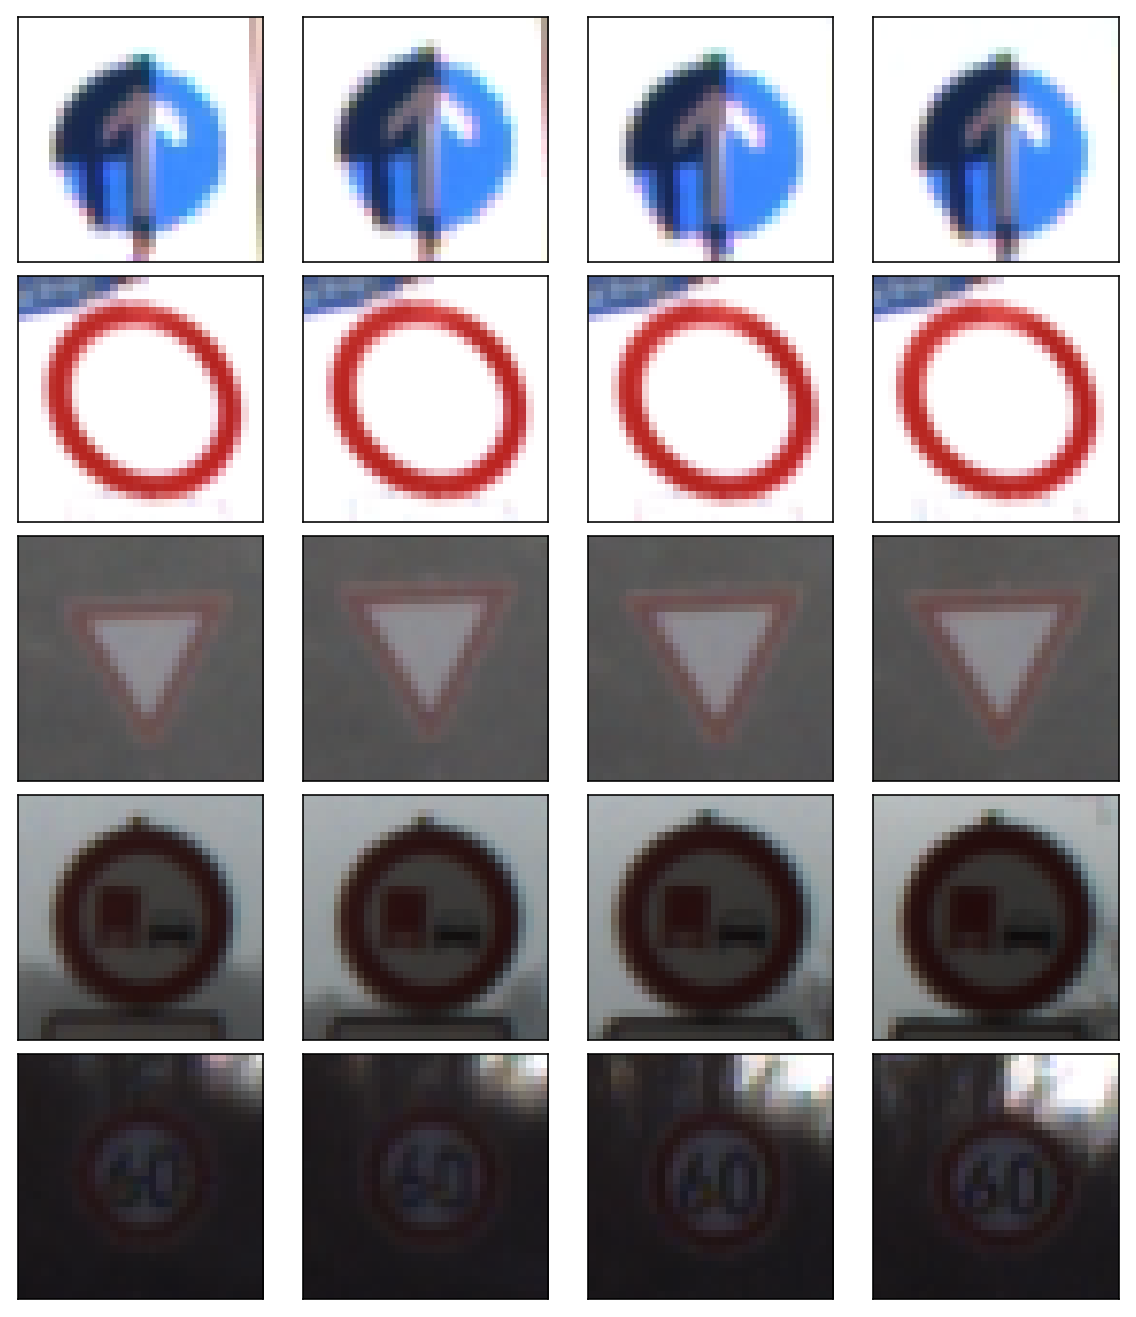

In [348]:
# plotting traffic sign images by taking several times different slices from the dataset
# at least 1 row
num_per_row = 4
index = random.randint(0, len(X_train) - num_per_row)
images = X_train[index:index + num_per_row].squeeze()

#add more rows
additional_rows = 4
for i in range(additional_rows):
    index = random.randint(0, len(X_train) - num_per_row)
    images = np.concatenate((images, X_train[index:index + num_per_row].squeeze()))


display_images(images)

In [349]:
# plotting plotting the count of each sign
from collections import Counter
traffic_sign_counter = Counter(y_train)
most_common = list(traffic_sign_counter.most_common()) # lets show only the first 30 most common signs
df = pd.DataFrame(most_common, columns=['Traffic_Sign', 'Cnt'])
# df.drop(df.columns[:1], inplace=True)
df

,Traffic_Sign,Cnt
0,2,2010
1,1,1980
2,13,1920
3,12,1890
4,38,1860
5,10,1800
6,4,1770
7,5,1650
8,25,1350
9,9,1320


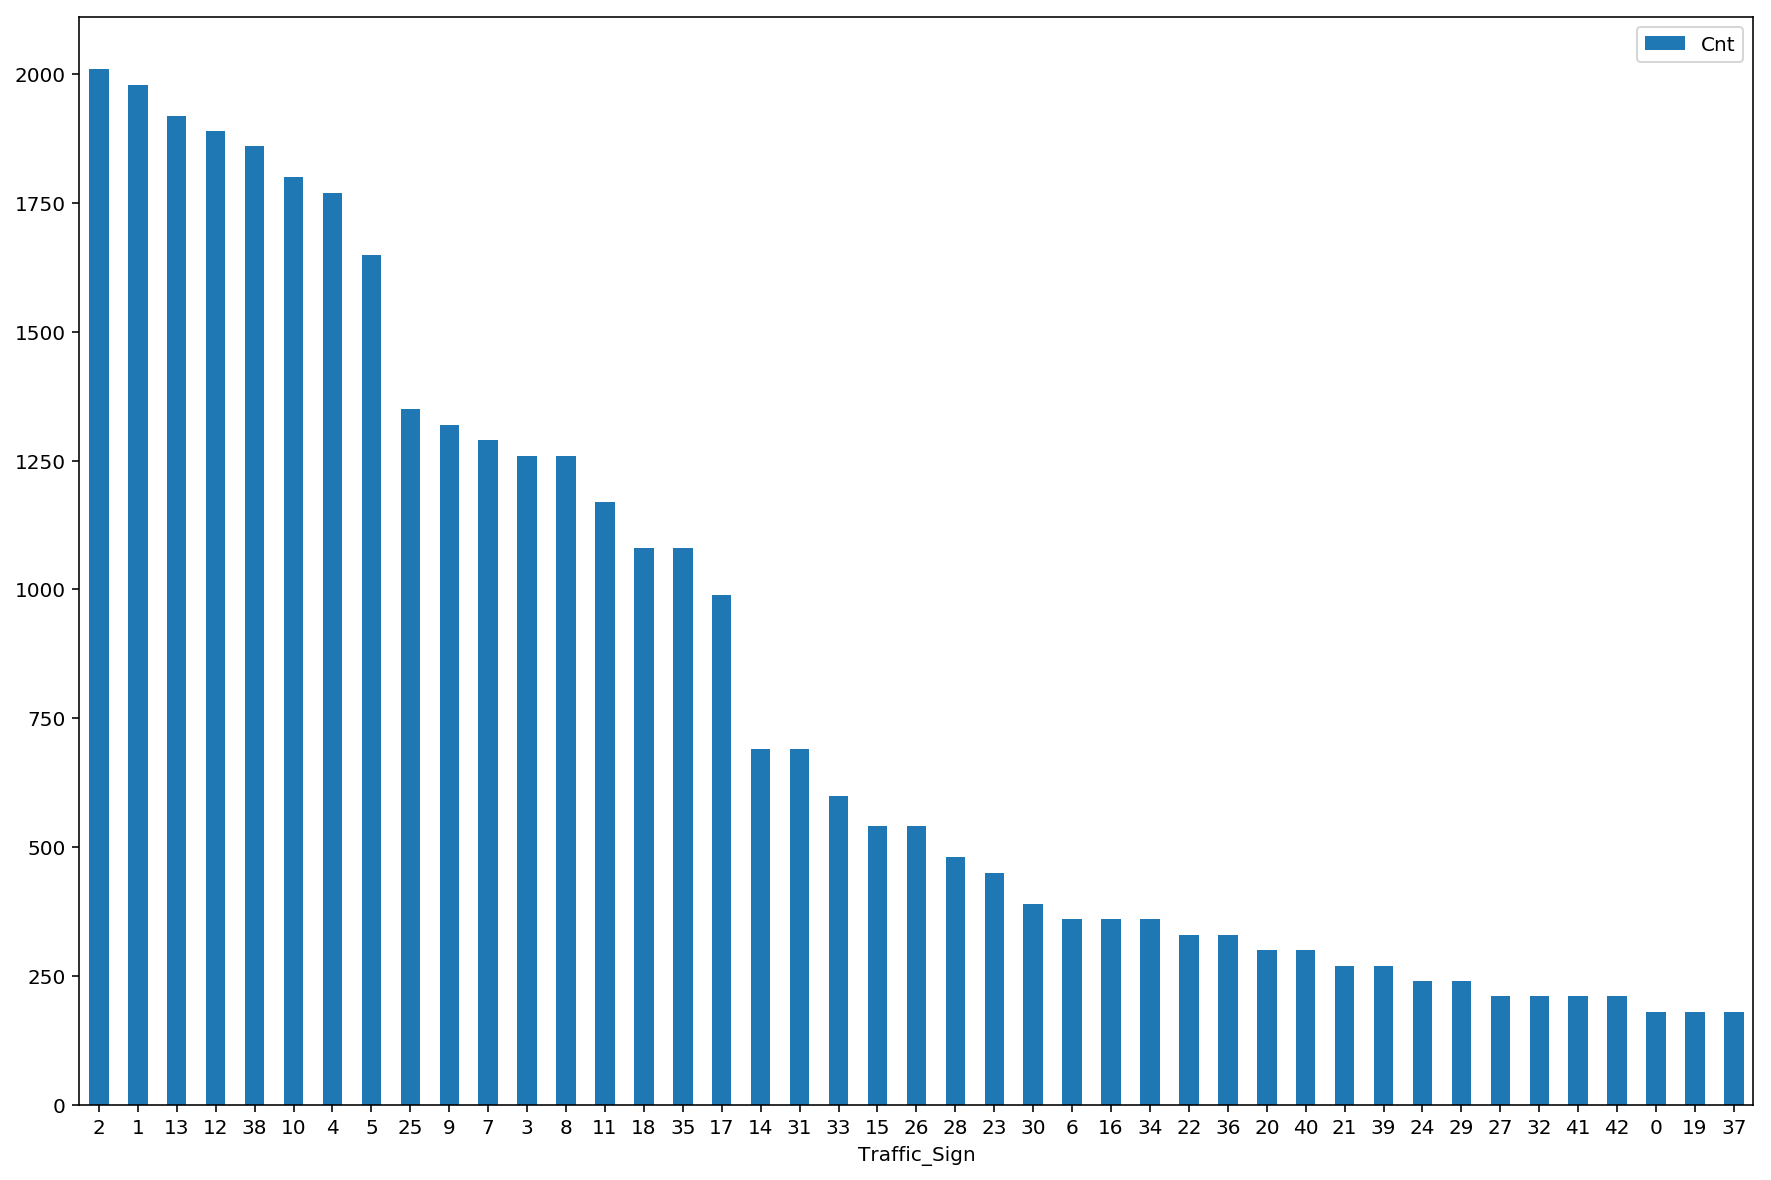

In [350]:
df.plot.bar(x='Traffic_Sign', y='Cnt', rot=0, figsize=(15,10), color='C0')

## Data augmentation

As we see, some signs are less represented. Therefore, in these cases, we need to make sure that the trained model is not biased towards the class that has more data. We could use different technics to augment the whole dataset (affine transformations, GANs, neural net to both augment and classify simultaneously, etc) but according to ["The Effectiveness of Data Augmentation in Image Classification using Deep Learning"](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)), traditional transformations consist of using a combination of affine transformations to manipulate the training data gives a good result.

Let's apply different affine transformations like shearing, scaling, translation, rotation and some other transformations like brigtness changes

### Illumination augmentation

In [351]:
index = random.randint(0, len(X_train) - num_per_row)
image = X_train[index]

In [357]:
# Changing randomly the brightness.
# We will generate images with different brightness by first converting images to HSV, 
# scaling up or down the V channel and converting back to the RGB channel.
def brightness_change(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 0.5 + np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

(32, 32, 3)
Traffic sign: 9


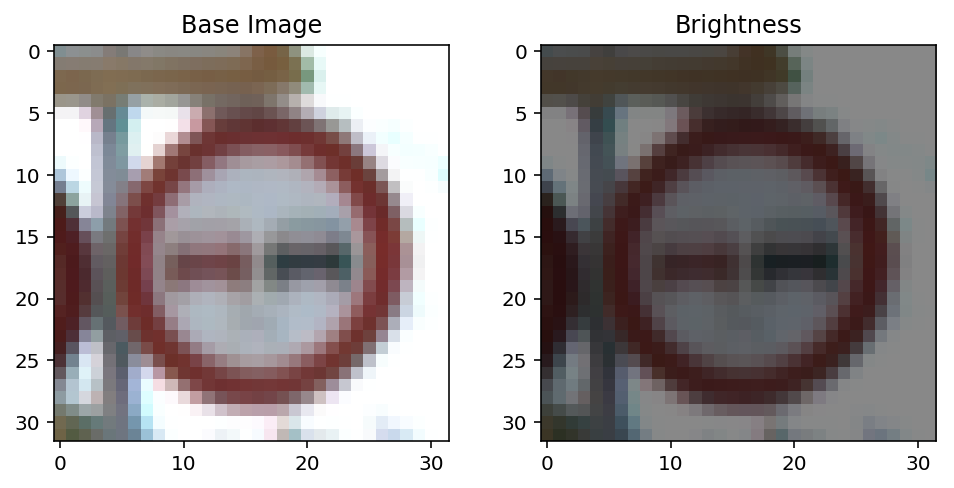

In [360]:
brightness_image = brightness_change(image)
print(brightness_image.shape)

print("Traffic sign: {}".format(y_train[index]))
fig, ax = plt.subplots(figsize = (8, 8))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(brightness_image)
plt.title('Brightness')
plt.show()

### Adding Noise

In [361]:
# def add_salt_pepper_noise(img_original):
#     img = img_original.copy()
#     rows, cols, _ = img.shape
#     salt_vs_pepper = 0.2
#     amount = 0.004
#     num_salt = np.ceil(amount * img[0].size * salt_vs_pepper)
#     num_pepper = np.ceil(amount * img[0].size * (1.0 - salt_vs_pepper))
    
#     # add salt noise
#     for counter in range(random.randint(3, 15)):
#         coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
#         img[coords[0], coords[1], :] = 255

#         # add pepper noise
#         coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
#         img[coords[0], coords[1], :] = 0
#     return img

def add_salt_pepper(image):
    row, col, ch = image.shape
    salt_vs_pepper = 0.5
    amount = 0.004
    out = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * image.size * salt_vs_pepper)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    out[coords[0], coords[1], :] = 255

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - salt_vs_pepper))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords[0], coords[1], :] = 0
    return out

(32, 32, 3)
Traffic sign: 9


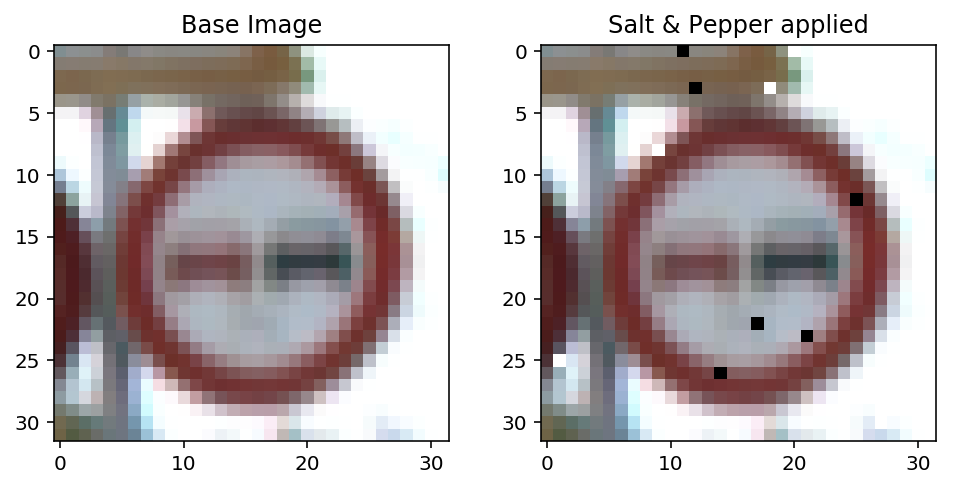

In [362]:
image_salt_pepper = add_salt_pepper(image)
print(image_salt_pepper.shape)
print("Traffic sign: {}".format(y_train[index]))
fig, ax = plt.subplots(figsize = (8, 8))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(image_salt_pepper)
plt.title('Salt & Pepper applied')
plt.show()

### Affine transformations

In [363]:
from skimage.util import crop
from skimage.transform import resize

def central_scale_image(img):
    """
    Crop the center and then scale it
    : x_images: List of images as tensor.  The image shape is (32, 32, 3)
    : y_labels: List of labels that will also be augmented accordinglyto the resizing
    : return: (resized_images, augmented_labels)
    """
    #use a random scale in the intervale [0.75, 0.95]
    scale = random.uniform(0.85, 1)
    image_size = img.shape
    before_1 = after_1 = (image_size[0] - scale * image_size[0]) / 2.0
    before_2 = after_2 = (image_size[1] - scale * image_size[1]) / 2.0
    crop_width = ((before_1, after_1), (before_2, after_2), (0, 0))
    scaled = crop(img, crop_width)
    scaled = resize(scaled, image_size)
    
    return scaled

Traffic sign: 9


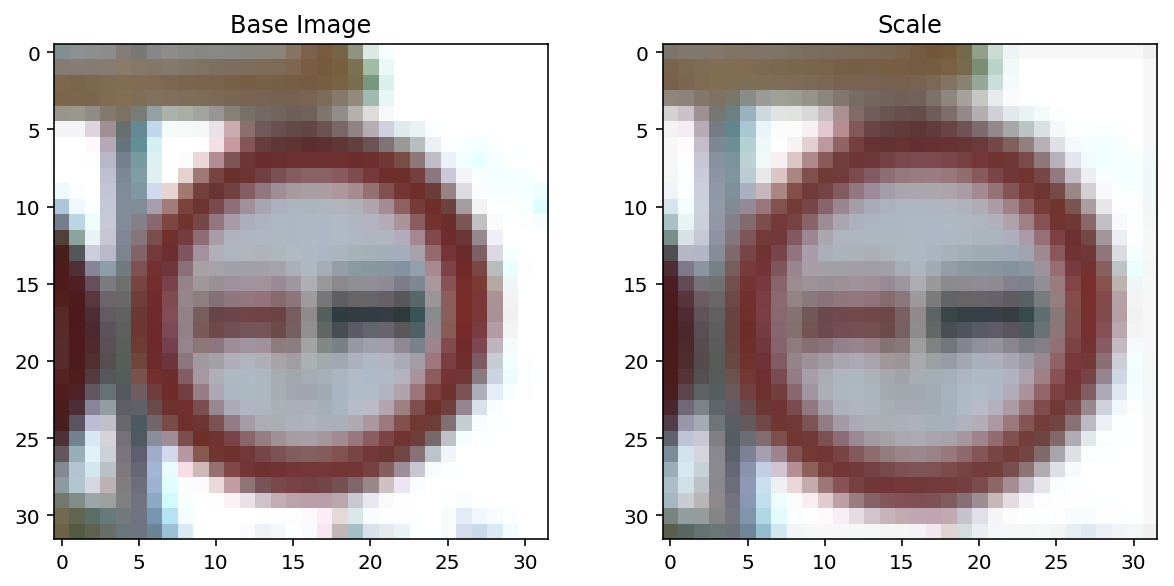

In [366]:
image_scale = central_scale_image(image)
print("Traffic sign: {}".format(y_train[index]))
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(image_scale)
plt.title('Scale')
plt.show()

In [367]:
def perspective_transformation(image, translate_limit=3, angle_limit = 15):
    Width, Height, Channel = image.shape
    
    center = np.array([Width / 2., Height / 2.])
    
    angle = np.random.uniform(low=-1, high=1) * angle_limit/180. * math.pi
    scale_limit = 0.1
    scale = np.random.uniform(low=-1, high=1) * scale_limit + 1
    cc = scale*math.cos(angle)
    ss = scale*math.sin(angle)
    rotation= np.array([[cc, ss],[-ss,cc]])
    
    translation = np.random.uniform(low=-1, high=1, size=(1,2)) * translate_limit

    pts1 = np.array([[0., 0.], [0., Height], [Width, Height], [Width, 0.]])
    pts2 = np.matmul(pts1 - center, rotation) + center  + translation
    
    # distortion
    distort_limit = 3
    distort = np.random.standard_normal(size=(4,2)) * distort_limit
    pts2 = pts2 + distort
    
    matrix  = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32))
    perspective_img = cv2.warpPerspective(image, matrix, (Width, Height), flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)  
    return perspective_img

Traffic sign: 9


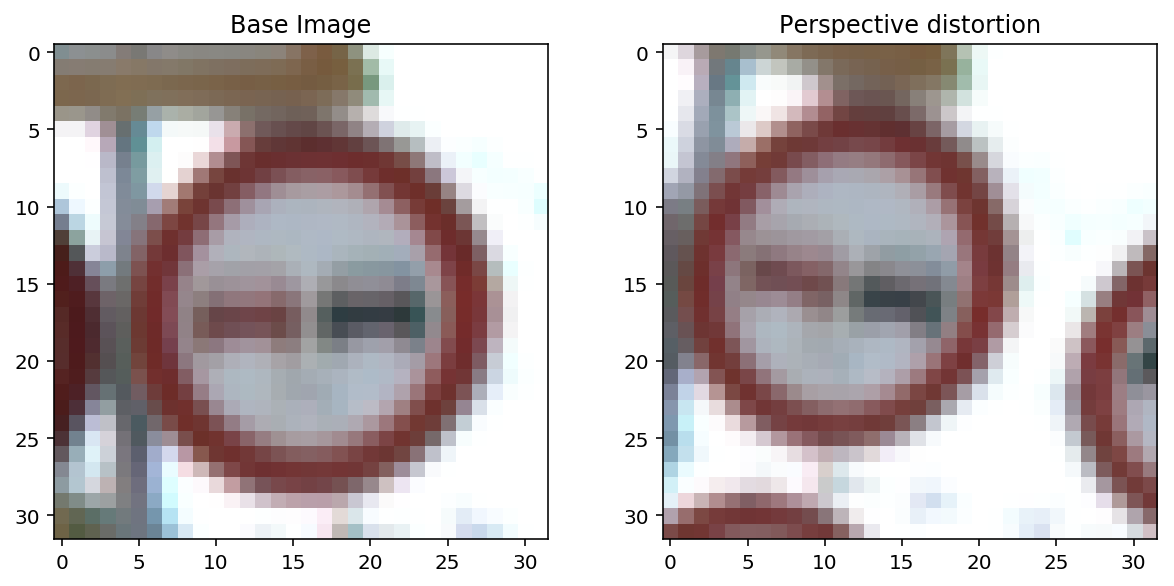

In [368]:
image_perspective_transfrom = perspective_transformation(image)
print("Traffic sign: {}".format(y_train[index]))
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(image_perspective_transfrom)
plt.title('Perspective distortion')
plt.show()

### Combination of technics

Let's apply all the combination above in order to augment our dataset. We will augment our databse in order to have around 5000 samples per classleading to a dataset of 215K samples.

In [370]:
def transform(img):
    # brightness
    transformed_img = brightness_change(img) 
    
    # perspective transformation
    transformed_img = perspective_transformation(transformed_img)
    #scaling
#     transformed_img = central_scale_image(transformed_img)

    # salt & pepper noising
#     apply_salt_pepper = random.randint(0, 1)
#     if apply_salt_pepper:
#         transformed_img = add_salt_pepper(transformed_img)
    
     
    return transformed_img

(32, 32, 3)
Traffic sign: 9


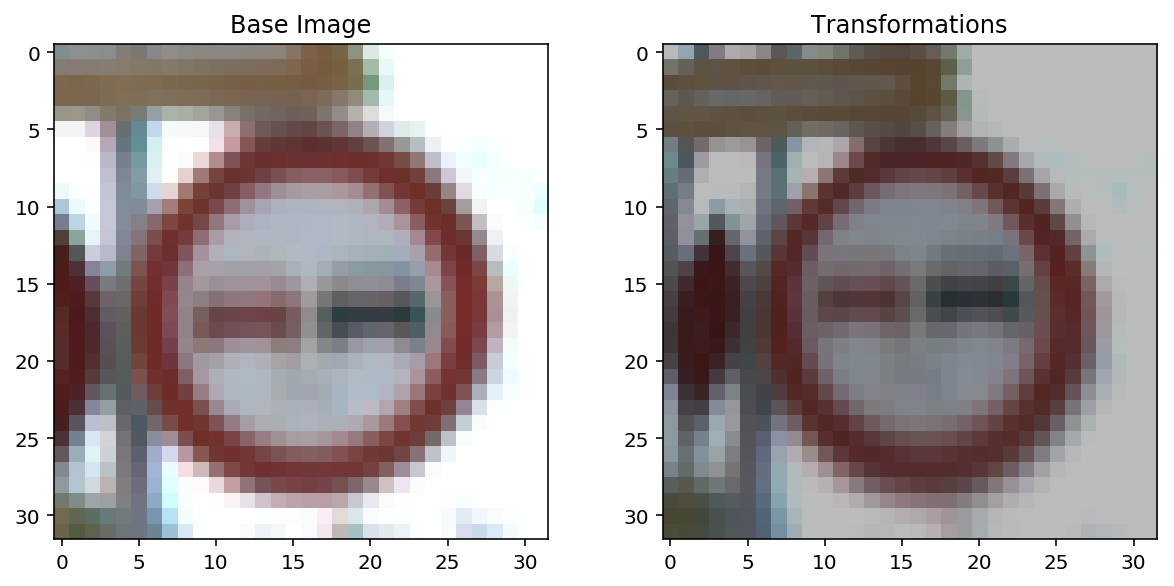

In [373]:
transform_img = transform(image)
print(transform_img.shape)
print("Traffic sign: {}".format(y_train[index]))
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(transform_img)
plt.title('Transformations')
plt.show()

### Augmentations

In [374]:
# shut down UserWarning from skimage
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [409]:
samples_per_class = 5000
augmented_imgs = []
augmented_labels = []

counter = 0

for index, image in enumerate(X_train):
    counter += 1
    label = y_train[index]
    # let's find how many samples we are missing for a given class 
    # in order to reach a total of samples_per_class per class
    missing_num = samples_per_class - traffic_sign_counter[label]
    
    # find how many images we should generate from a single image taken from X_train
    # in order to augment the class it represents
    total_loops_per_original_img = math.ceil(missing_num / traffic_sign_counter[label])
    
    for i in range(total_loops_per_original_img):
        new_img = transform(image)
        
        augmented_imgs.append(new_img)
        augmented_labels.append(label)
    
    if(counter % 100 == 0):
        print("{} out of {} processed".format(counter + 1, n_train))

101 out of 34799 processed
201 out of 34799 processed
301 out of 34799 processed
401 out of 34799 processed
501 out of 34799 processed
601 out of 34799 processed
701 out of 34799 processed
801 out of 34799 processed
901 out of 34799 processed
1001 out of 34799 processed
1101 out of 34799 processed
1201 out of 34799 processed
1301 out of 34799 processed
1401 out of 34799 processed
1501 out of 34799 processed
1601 out of 34799 processed
1701 out of 34799 processed
1801 out of 34799 processed
1901 out of 34799 processed
2001 out of 34799 processed
2101 out of 34799 processed
2201 out of 34799 processed
2301 out of 34799 processed
2401 out of 34799 processed
2501 out of 34799 processed
2601 out of 34799 processed
2701 out of 34799 processed
2801 out of 34799 processed
2901 out of 34799 processed
3001 out of 34799 processed
3101 out of 34799 processed
3201 out of 34799 processed
3301 out of 34799 processed
3401 out of 34799 processed
3501 out of 34799 processed
3601 out of 34799 processed
3

29201 out of 34799 processed
29301 out of 34799 processed
29401 out of 34799 processed
29501 out of 34799 processed
29601 out of 34799 processed
29701 out of 34799 processed
29801 out of 34799 processed
29901 out of 34799 processed
30001 out of 34799 processed
30101 out of 34799 processed
30201 out of 34799 processed
30301 out of 34799 processed
30401 out of 34799 processed
30501 out of 34799 processed
30601 out of 34799 processed
30701 out of 34799 processed
30801 out of 34799 processed
30901 out of 34799 processed
31001 out of 34799 processed
31101 out of 34799 processed
31201 out of 34799 processed
31301 out of 34799 processed
31401 out of 34799 processed
31501 out of 34799 processed
31601 out of 34799 processed
31701 out of 34799 processed
31801 out of 34799 processed
31901 out of 34799 processed
32001 out of 34799 processed
32101 out of 34799 processed
32201 out of 34799 processed
32301 out of 34799 processed
32401 out of 34799 processed
32501 out of 34799 processed
32601 out of 3

In [410]:
augmented_imgs = np.array(augmented_imgs)
augmented_labels = np.array(augmented_labels)
assert len(augmented_labels) == len(augmented_imgs), "The size of the generated labels should be equal \
to the size of the the newly generated images"
print("Shape of the new images: {}".format(augmented_imgs.shape))

Shape of the new images: (194482, 32, 32, 3)


In [411]:
# compute the portions in % of the x_train dataset & augmented_imgs from the whole augmented dataset
total_dataset_size = len(augmented_imgs) + n_train
test_proportion = 0.01 * math.ceil(n_train * 100 / total_dataset_size)
augmented_proportion = 1 - test_proportion   
print("X_test proportion from the whole dataset: {}%".format(test_proportion))
print("Augmented set proportion from the whole dataset: {}%".format(augmented_proportion))

X_test proportion from the whole dataset: 0.16%
Augmented set proportion from the whole dataset: 0.84%


In [412]:
# let's shuffle
augmented_imgs, augmented_labels = shuffle(augmented_imgs, augmented_labels)

In [413]:
def save_data(folder_path, X_train, y_train, images, labels, total, process_image=None):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    batch_size = 64
    bach_train_size = math.ceil(test_proportion * batch_size)
    batch_augmented_size = batch_size - bach_train_size

    for i in range(total):
        if i % 64 == 0:
            print("Epoch {} / {}".format(i, total))
        batch_imgs = []
        batch_labels = []
        # each batch is made of ~16% of X_train & 84% of newly generated images
        start = i * bach_train_size
        end = start + bach_train_size
        batch_imgs.extend(X_train[start:end]) # test_proportion% of batch_size
        batch_labels.extend(y_train[start:end])
        
        start = i * batch_augmented_size
        end = start + batch_augmented_size
        batch_imgs.extend(images[start:end])
        batch_labels.extend(labels[start:end])
        
        if process_image:
            batch_imgs = [process_image(x) for x in batch_imgs]
            
        # save now this batch
        
        filename = folder_path + 'preprocess_batch_' + str(i) + '.p'
        
        batch_imgs = np.array(batch_imgs, dtype = np.float32)
        batch_labels = np.array(batch_labels, dtype = np.uint8)
        pickle.dump((batch_imgs, batch_labels), open(filename, 'wb'))
        
    print("Dataset saved")
    
        

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [ ]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [444]:
def grayscale(img, show=False):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if not show:
        gray = gray[:, :, np.newaxis]
    return gray
# tests.test_grayscale(grayscale)
# print(grayscale(X_train[0]))


(32, 32)
2


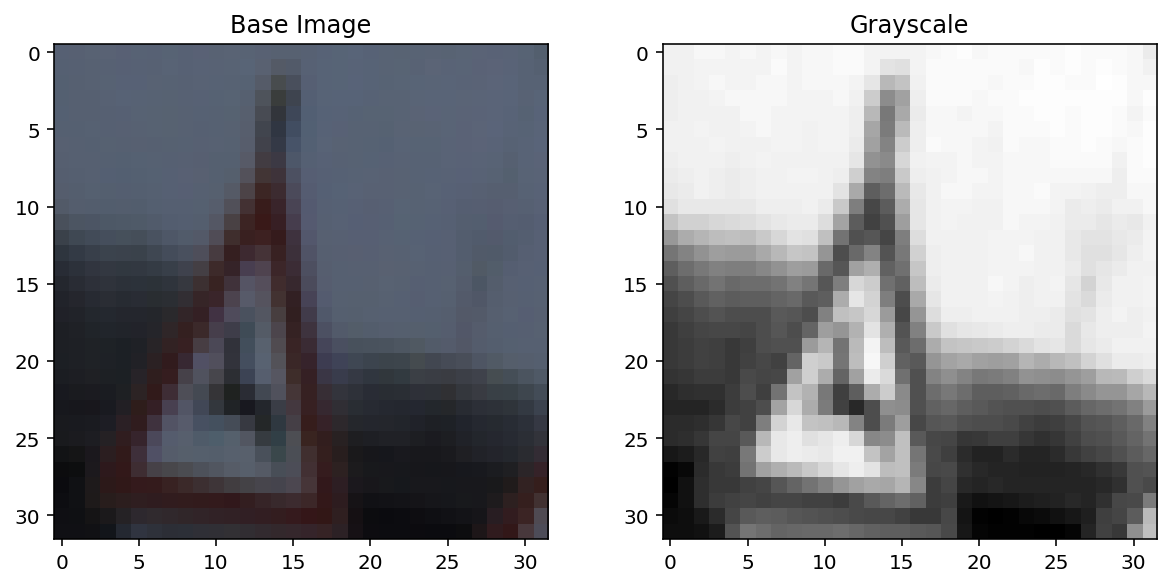

In [445]:
i = random.randint(0, len(augmented_imgs))
img = augmented_imgs[i].squeeze()
gray = grayscale(img, show=True)
print(gray.shape)
print(len(gray.shape))
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.show()

In [90]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x / 255
    return x
# tests.test_normalize(normalize)

In [452]:
def process_image(image):
#     denoised = denoise(image)
    gray = grayscale(image)
    normalized = normalize(gray)
#     normalized = normalize(image)
    
    return normalized

## Checkpoint

Save the the whole preprocessed dataset made of the X_train & augmented dataset. No necessity to augment the dataset from this point. We can directly start here.

In [453]:
preprocessed_batches_folder = "preprocessed_batches/"
save_data(preprocessed_batches_folder, X_train, y_train, 
          augmented_imgs, augmented_labels, 
          total_dataset_size, process_image)

Epoch 0 / 229281
Epoch 64 / 229281
Epoch 128 / 229281
Epoch 192 / 229281
Epoch 256 / 229281
Epoch 320 / 229281
Epoch 384 / 229281
Epoch 448 / 229281
Epoch 512 / 229281
Epoch 576 / 229281
Epoch 640 / 229281
Epoch 704 / 229281
Epoch 768 / 229281
Epoch 832 / 229281
Epoch 896 / 229281
Epoch 960 / 229281
Epoch 1024 / 229281
Epoch 1088 / 229281
Epoch 1152 / 229281
Epoch 1216 / 229281
Epoch 1280 / 229281
Epoch 1344 / 229281
Epoch 1408 / 229281
Epoch 1472 / 229281
Epoch 1536 / 229281
Epoch 1600 / 229281
Epoch 1664 / 229281
Epoch 1728 / 229281
Epoch 1792 / 229281
Epoch 1856 / 229281
Epoch 1920 / 229281
Epoch 1984 / 229281
Epoch 2048 / 229281
Epoch 2112 / 229281
Epoch 2176 / 229281
Epoch 2240 / 229281
Epoch 2304 / 229281
Epoch 2368 / 229281
Epoch 2432 / 229281
Epoch 2496 / 229281
Epoch 2560 / 229281
Epoch 2624 / 229281
Epoch 2688 / 229281
Epoch 2752 / 229281
Epoch 2816 / 229281
Epoch 2880 / 229281
Epoch 2944 / 229281
Epoch 3008 / 229281
Epoch 3072 / 229281
Epoch 3136 / 229281
Epoch 3200 / 229281

Epoch 26112 / 229281
Epoch 26176 / 229281
Epoch 26240 / 229281
Epoch 26304 / 229281
Epoch 26368 / 229281
Epoch 26432 / 229281
Epoch 26496 / 229281
Epoch 26560 / 229281
Epoch 26624 / 229281
Epoch 26688 / 229281
Epoch 26752 / 229281
Epoch 26816 / 229281
Epoch 26880 / 229281
Epoch 26944 / 229281
Epoch 27008 / 229281
Epoch 27072 / 229281
Epoch 27136 / 229281
Epoch 27200 / 229281
Epoch 27264 / 229281
Epoch 27328 / 229281
Epoch 27392 / 229281
Epoch 27456 / 229281
Epoch 27520 / 229281
Epoch 27584 / 229281
Epoch 27648 / 229281
Epoch 27712 / 229281
Epoch 27776 / 229281
Epoch 27840 / 229281
Epoch 27904 / 229281
Epoch 27968 / 229281
Epoch 28032 / 229281
Epoch 28096 / 229281
Epoch 28160 / 229281
Epoch 28224 / 229281
Epoch 28288 / 229281
Epoch 28352 / 229281
Epoch 28416 / 229281
Epoch 28480 / 229281
Epoch 28544 / 229281
Epoch 28608 / 229281
Epoch 28672 / 229281
Epoch 28736 / 229281
Epoch 28800 / 229281
Epoch 28864 / 229281
Epoch 28928 / 229281
Epoch 28992 / 229281
Epoch 29056 / 229281
Epoch 29120 /

Epoch 51712 / 229281
Epoch 51776 / 229281
Epoch 51840 / 229281
Epoch 51904 / 229281
Epoch 51968 / 229281
Epoch 52032 / 229281
Epoch 52096 / 229281
Epoch 52160 / 229281
Epoch 52224 / 229281
Epoch 52288 / 229281
Epoch 52352 / 229281
Epoch 52416 / 229281
Epoch 52480 / 229281
Epoch 52544 / 229281
Epoch 52608 / 229281
Epoch 52672 / 229281
Epoch 52736 / 229281
Epoch 52800 / 229281
Epoch 52864 / 229281
Epoch 52928 / 229281
Epoch 52992 / 229281
Epoch 53056 / 229281
Epoch 53120 / 229281
Epoch 53184 / 229281
Epoch 53248 / 229281
Epoch 53312 / 229281
Epoch 53376 / 229281
Epoch 53440 / 229281
Epoch 53504 / 229281
Epoch 53568 / 229281
Epoch 53632 / 229281
Epoch 53696 / 229281
Epoch 53760 / 229281
Epoch 53824 / 229281
Epoch 53888 / 229281
Epoch 53952 / 229281
Epoch 54016 / 229281
Epoch 54080 / 229281
Epoch 54144 / 229281
Epoch 54208 / 229281
Epoch 54272 / 229281
Epoch 54336 / 229281
Epoch 54400 / 229281
Epoch 54464 / 229281
Epoch 54528 / 229281
Epoch 54592 / 229281
Epoch 54656 / 229281
Epoch 54720 /

Epoch 77312 / 229281
Epoch 77376 / 229281
Epoch 77440 / 229281
Epoch 77504 / 229281
Epoch 77568 / 229281
Epoch 77632 / 229281
Epoch 77696 / 229281
Epoch 77760 / 229281
Epoch 77824 / 229281
Epoch 77888 / 229281
Epoch 77952 / 229281
Epoch 78016 / 229281
Epoch 78080 / 229281
Epoch 78144 / 229281
Epoch 78208 / 229281
Epoch 78272 / 229281
Epoch 78336 / 229281
Epoch 78400 / 229281
Epoch 78464 / 229281
Epoch 78528 / 229281
Epoch 78592 / 229281
Epoch 78656 / 229281
Epoch 78720 / 229281
Epoch 78784 / 229281
Epoch 78848 / 229281
Epoch 78912 / 229281
Epoch 78976 / 229281
Epoch 79040 / 229281
Epoch 79104 / 229281
Epoch 79168 / 229281
Epoch 79232 / 229281
Epoch 79296 / 229281
Epoch 79360 / 229281
Epoch 79424 / 229281
Epoch 79488 / 229281
Epoch 79552 / 229281
Epoch 79616 / 229281
Epoch 79680 / 229281
Epoch 79744 / 229281
Epoch 79808 / 229281
Epoch 79872 / 229281
Epoch 79936 / 229281
Epoch 80000 / 229281
Epoch 80064 / 229281
Epoch 80128 / 229281
Epoch 80192 / 229281
Epoch 80256 / 229281
Epoch 80320 /

Epoch 102784 / 229281
Epoch 102848 / 229281
Epoch 102912 / 229281
Epoch 102976 / 229281
Epoch 103040 / 229281
Epoch 103104 / 229281
Epoch 103168 / 229281
Epoch 103232 / 229281
Epoch 103296 / 229281
Epoch 103360 / 229281
Epoch 103424 / 229281
Epoch 103488 / 229281
Epoch 103552 / 229281
Epoch 103616 / 229281
Epoch 103680 / 229281
Epoch 103744 / 229281
Epoch 103808 / 229281
Epoch 103872 / 229281
Epoch 103936 / 229281
Epoch 104000 / 229281
Epoch 104064 / 229281
Epoch 104128 / 229281
Epoch 104192 / 229281
Epoch 104256 / 229281
Epoch 104320 / 229281
Epoch 104384 / 229281
Epoch 104448 / 229281
Epoch 104512 / 229281
Epoch 104576 / 229281
Epoch 104640 / 229281
Epoch 104704 / 229281
Epoch 104768 / 229281
Epoch 104832 / 229281
Epoch 104896 / 229281
Epoch 104960 / 229281
Epoch 105024 / 229281
Epoch 105088 / 229281
Epoch 105152 / 229281
Epoch 105216 / 229281
Epoch 105280 / 229281
Epoch 105344 / 229281
Epoch 105408 / 229281
Epoch 105472 / 229281
Epoch 105536 / 229281
Epoch 105600 / 229281
Epoch 1056

Epoch 127168 / 229281
Epoch 127232 / 229281
Epoch 127296 / 229281
Epoch 127360 / 229281
Epoch 127424 / 229281
Epoch 127488 / 229281
Epoch 127552 / 229281
Epoch 127616 / 229281
Epoch 127680 / 229281
Epoch 127744 / 229281
Epoch 127808 / 229281
Epoch 127872 / 229281
Epoch 127936 / 229281
Epoch 128000 / 229281
Epoch 128064 / 229281
Epoch 128128 / 229281
Epoch 128192 / 229281
Epoch 128256 / 229281
Epoch 128320 / 229281
Epoch 128384 / 229281
Epoch 128448 / 229281
Epoch 128512 / 229281
Epoch 128576 / 229281
Epoch 128640 / 229281
Epoch 128704 / 229281
Epoch 128768 / 229281
Epoch 128832 / 229281
Epoch 128896 / 229281
Epoch 128960 / 229281
Epoch 129024 / 229281
Epoch 129088 / 229281
Epoch 129152 / 229281
Epoch 129216 / 229281
Epoch 129280 / 229281
Epoch 129344 / 229281
Epoch 129408 / 229281
Epoch 129472 / 229281
Epoch 129536 / 229281
Epoch 129600 / 229281
Epoch 129664 / 229281
Epoch 129728 / 229281
Epoch 129792 / 229281
Epoch 129856 / 229281
Epoch 129920 / 229281
Epoch 129984 / 229281
Epoch 1300

Epoch 151488 / 229281
Epoch 151552 / 229281
Epoch 151616 / 229281
Epoch 151680 / 229281
Epoch 151744 / 229281
Epoch 151808 / 229281
Epoch 151872 / 229281
Epoch 151936 / 229281
Epoch 152000 / 229281
Epoch 152064 / 229281
Epoch 152128 / 229281
Epoch 152192 / 229281
Epoch 152256 / 229281
Epoch 152320 / 229281
Epoch 152384 / 229281
Epoch 152448 / 229281
Epoch 152512 / 229281
Epoch 152576 / 229281
Epoch 152640 / 229281
Epoch 152704 / 229281
Epoch 152768 / 229281
Epoch 152832 / 229281
Epoch 152896 / 229281
Epoch 152960 / 229281
Epoch 153024 / 229281
Epoch 153088 / 229281
Epoch 153152 / 229281
Epoch 153216 / 229281
Epoch 153280 / 229281
Epoch 153344 / 229281
Epoch 153408 / 229281
Epoch 153472 / 229281
Epoch 153536 / 229281
Epoch 153600 / 229281
Epoch 153664 / 229281
Epoch 153728 / 229281
Epoch 153792 / 229281
Epoch 153856 / 229281
Epoch 153920 / 229281
Epoch 153984 / 229281
Epoch 154048 / 229281
Epoch 154112 / 229281
Epoch 154176 / 229281
Epoch 154240 / 229281
Epoch 154304 / 229281
Epoch 1543

Epoch 175808 / 229281
Epoch 175872 / 229281
Epoch 175936 / 229281
Epoch 176000 / 229281
Epoch 176064 / 229281
Epoch 176128 / 229281
Epoch 176192 / 229281
Epoch 176256 / 229281
Epoch 176320 / 229281
Epoch 176384 / 229281
Epoch 176448 / 229281
Epoch 176512 / 229281
Epoch 176576 / 229281
Epoch 176640 / 229281
Epoch 176704 / 229281
Epoch 176768 / 229281
Epoch 176832 / 229281
Epoch 176896 / 229281
Epoch 176960 / 229281
Epoch 177024 / 229281
Epoch 177088 / 229281
Epoch 177152 / 229281
Epoch 177216 / 229281
Epoch 177280 / 229281
Epoch 177344 / 229281
Epoch 177408 / 229281
Epoch 177472 / 229281
Epoch 177536 / 229281
Epoch 177600 / 229281
Epoch 177664 / 229281
Epoch 177728 / 229281
Epoch 177792 / 229281
Epoch 177856 / 229281
Epoch 177920 / 229281
Epoch 177984 / 229281
Epoch 178048 / 229281
Epoch 178112 / 229281
Epoch 178176 / 229281
Epoch 178240 / 229281
Epoch 178304 / 229281
Epoch 178368 / 229281
Epoch 178432 / 229281
Epoch 178496 / 229281
Epoch 178560 / 229281
Epoch 178624 / 229281
Epoch 1786

Epoch 200128 / 229281
Epoch 200192 / 229281
Epoch 200256 / 229281
Epoch 200320 / 229281
Epoch 200384 / 229281
Epoch 200448 / 229281
Epoch 200512 / 229281
Epoch 200576 / 229281
Epoch 200640 / 229281
Epoch 200704 / 229281
Epoch 200768 / 229281
Epoch 200832 / 229281
Epoch 200896 / 229281
Epoch 200960 / 229281
Epoch 201024 / 229281
Epoch 201088 / 229281
Epoch 201152 / 229281
Epoch 201216 / 229281
Epoch 201280 / 229281
Epoch 201344 / 229281
Epoch 201408 / 229281
Epoch 201472 / 229281
Epoch 201536 / 229281
Epoch 201600 / 229281
Epoch 201664 / 229281
Epoch 201728 / 229281
Epoch 201792 / 229281
Epoch 201856 / 229281
Epoch 201920 / 229281
Epoch 201984 / 229281
Epoch 202048 / 229281
Epoch 202112 / 229281
Epoch 202176 / 229281
Epoch 202240 / 229281
Epoch 202304 / 229281
Epoch 202368 / 229281
Epoch 202432 / 229281
Epoch 202496 / 229281
Epoch 202560 / 229281
Epoch 202624 / 229281
Epoch 202688 / 229281
Epoch 202752 / 229281
Epoch 202816 / 229281
Epoch 202880 / 229281
Epoch 202944 / 229281
Epoch 2030

Epoch 224384 / 229281
Epoch 224448 / 229281
Epoch 224512 / 229281
Epoch 224576 / 229281
Epoch 224640 / 229281
Epoch 224704 / 229281
Epoch 224768 / 229281
Epoch 224832 / 229281
Epoch 224896 / 229281
Epoch 224960 / 229281
Epoch 225024 / 229281
Epoch 225088 / 229281
Epoch 225152 / 229281
Epoch 225216 / 229281
Epoch 225280 / 229281
Epoch 225344 / 229281
Epoch 225408 / 229281
Epoch 225472 / 229281
Epoch 225536 / 229281
Epoch 225600 / 229281
Epoch 225664 / 229281
Epoch 225728 / 229281
Epoch 225792 / 229281
Epoch 225856 / 229281
Epoch 225920 / 229281
Epoch 225984 / 229281
Epoch 226048 / 229281
Epoch 226112 / 229281
Epoch 226176 / 229281
Epoch 226240 / 229281
Epoch 226304 / 229281
Epoch 226368 / 229281
Epoch 226432 / 229281
Epoch 226496 / 229281
Epoch 226560 / 229281
Epoch 226624 / 229281
Epoch 226688 / 229281
Epoch 226752 / 229281
Epoch 226816 / 229281
Epoch 226880 / 229281
Epoch 226944 / 229281
Epoch 227008 / 229281
Epoch 227072 / 229281
Epoch 227136 / 229281
Epoch 227200 / 229281
Epoch 2272

### Model Architecture

In [240]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def convNet(x, n_classes, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv_ksize = [5, 5]
    conv_num_outputs = 6
    weights = tf.Variable(tf.truncated_normal(shape=[conv_ksize[0], conv_ksize[1], x.shape[3].value, conv_num_outputs],
                                              stddev=sigma, mean=mu), name='weights')
    bias = tf.Variable(tf.zeros(conv_num_outputs), name='bias')
    
    strides = [1, 1, 1, 1]
    conv_layer1 = tf.nn.conv2d(x, weights, strides, padding='VALID')
    conv_layer1 = tf.nn.bias_add(conv_layer1, bias)

    # Activation.
    conv_layer1 = tf.nn.relu(conv_layer1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    filter_shape = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    conv_layer1 = tf.nn.max_pool(conv_layer1, filter_shape, strides, padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv_ksize = [5, 5]
    conv_num_outputs = 16
    weights = tf.Variable(tf.truncated_normal(shape=[conv_ksize[0], conv_ksize[1], conv_layer1.shape[3].value, conv_num_outputs],
                                              stddev=sigma, mean=mu), name='weights')
    bias = tf.Variable(tf.zeros(conv_num_outputs), name='bias')
    
    strides = [1, 1, 1, 1]
    conv_layer2 = tf.nn.conv2d(conv_layer1, weights, strides, padding='VALID')
    conv_layer2 = tf.nn.bias_add(conv_layer2, bias) 
    
    # Activation.
    conv_layer2 = tf.nn.relu(conv_layer2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    filter_shape = [1, 2, 2, 1]
    strides = [1, 2, 2, 1]
    conv_layer2 = tf.nn.max_pool(conv_layer2, filter_shape, strides, padding='VALID')

    # Flatten. Input = 5x5x64. Output = 400.
    shape = conv_layer2.get_shape().as_list()
    dim = np.prod(shape[1:])
    flatten = tf.reshape(conv_layer2, [-1, dim])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    dim = flatten.get_shape()[1].value
    num_outputs = 120
    weights = tf.Variable(tf.truncated_normal((dim, num_outputs), stddev=sigma, mean=mu))
    bias = tf.Variable(tf.zeros(num_outputs))
    fc1 = tf.add(tf.matmul(flatten, weights), bias)
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    dim = fc1.get_shape()[1].value
    num_outputs = 84
    weights = tf.Variable(tf.truncated_normal((dim, num_outputs), stddev=sigma, mean=mu))
    bias = tf.Variable(tf.zeros(num_outputs))
    fc2 = tf.add(tf.matmul(fc1, weights), bias)
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Apply regularization: Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    dim = fc2.get_shape()[1].value
    num_outputs = n_classes
    weights = tf.Variable(tf.truncated_normal((dim, num_outputs), stddev=sigma, mean=mu))
    bias = tf.Variable(tf.zeros(num_outputs))
    logits = tf.add(tf.matmul(fc2, weights), bias)
    
    
    return logits

In [472]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='features')
y = tf.placeholder(tf.int32, (None), name='labels')
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [476]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

rate = 0.001
EPOCHS = 100
BATCH_SIZE = 128

In [475]:
logits = convNet(x, n_classes, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model evaluation

In [477]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#### Load a batch

In [466]:
def load_batch(folder_path, batch_size, batch_i):
    # each file contains a batch of 64 files while the batch_size may be bigger than that.
    # let's compute how many files to load
    sample_per_file = 64
    num_files = batch_size // sample_per_file
    start = batch_i // sample_per_file
#     print("batch_i={}".format(batch_i))
    
    images = np.empty((0, 32, 32, 1))
    labels = np.empty((0))
    for i in range(num_files):
        index = start + i
#         print("i={}".format(i))
#         print("index={}".format(index))
                
        filename = folder_path + 'preprocess_batch_' + str(index) + '.p'
        features_batch, labels_batch = pickle.load(open(filename, mode='rb'))
        
        images = np.append(images, features_batch, axis=0)
        labels = np.append(labels, labels_batch, axis=0)
#         print(images.shape)
#         print(labels.shape)
#     print()
    
    return images.astype(np.float32), labels.astype(np.uint8)
        
#         print(labels.shape)

##### Test loading a random batch

In [467]:
# b = 256
# for i in range(0, 1024, b):
# #     print(i)
#     load_batch(preprocessed_batches_folder, b, i)
imgs, labels = load_batch(preprocessed_batches_folder, 128, 2)


In [458]:
# index = 90
# image = imgs[index].copy()
# image *= 255 # because we have normalized, so values are between 0-255
# label = labels[index]
# fig, ax = plt.subplots(figsize = (10, 10))
# plt.subplot(2, 2, 1)
# plt.imshow(image)
# plt.title('{}, {}'.format(label, signs_names['SignName'][label]))
# plt.show()

#### Train

In [459]:
X_valid_processed = [process_image(x) for x in X_valid]

In [460]:
X_valid_processed = np.array(X_valid_processed)

In [479]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     num_examples = len(X_train_processed)
    
#     print("Training...")
#     print()
#     for i in range(EPOCHS):
#         X_train_processed, y_train = shuffle(X_train_processed, y_train)
#         for offset in range(0, num_examples, BATCH_SIZE):
#             end = offset + BATCH_SIZE
#             batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
#             sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
#         validation_accuracy = evaluate(X_valid_processed, y_valid)
#         print("EPOCH {} ...".format(i + 1))
#         print("Validation Accuracy = {:.3f}".format(validation_accuracy))
#         print()
#     saver.save(sess, './traffic_sign_classifier')
#     print("Model saved")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # total_dataset_size
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, total_dataset_size, BATCH_SIZE):
            batch_x, batch_y = load_batch(preprocessed_batches_folder, BATCH_SIZE, offset)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_processed, y_valid)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './traffic_sign_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.551

EPOCH 2 ...
Validation Accuracy = 0.723

EPOCH 3 ...
Validation Accuracy = 0.804

EPOCH 4 ...
Validation Accuracy = 0.847

EPOCH 5 ...
Validation Accuracy = 0.872

EPOCH 6 ...
Validation Accuracy = 0.887

EPOCH 7 ...
Validation Accuracy = 0.886

EPOCH 8 ...
Validation Accuracy = 0.901

EPOCH 9 ...
Validation Accuracy = 0.904

EPOCH 10 ...
Validation Accuracy = 0.912

EPOCH 11 ...
Validation Accuracy = 0.920

EPOCH 12 ...
Validation Accuracy = 0.921

EPOCH 13 ...
Validation Accuracy = 0.932

EPOCH 14 ...
Validation Accuracy = 0.924

EPOCH 15 ...
Validation Accuracy = 0.924

EPOCH 16 ...
Validation Accuracy = 0.929

EPOCH 17 ...
Validation Accuracy = 0.932

EPOCH 18 ...
Validation Accuracy = 0.937

EPOCH 19 ...
Validation Accuracy = 0.927

EPOCH 20 ...
Validation Accuracy = 0.941

EPOCH 21 ...
Validation Accuracy = 0.936

EPOCH 22 ...
Validation Accuracy = 0.938

EPOCH 23 ...
Validation Accuracy = 0.928

EPOCH 24 ...
Validation Accura

KeyboardInterrupt: 

### Evaluate the Model
Evaluate the performance of the model on the test set. We do it only once.

In [87]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic_sign_classifier
Test Accuracy = 0.904


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [94]:
import matplotlib.image as mpimg
import os
import urllib

In [121]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
extract_path = './data_web'
def download_images_web(extract_path, urls):
    if os.path.exists(extract_path):
        files = os.listdir(extract_path)
        if len(files) > 0:
            print('Images already downloaded')
            return
        
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
        
    for index, url in enumerate(urls):
        name = "image_" + str(index) + ".jpg"
        path = os.path.join(extract_path, name)
        f = open(path,'wb')
        f.write(urllib.request.urlopen(url).read())
        f.close()
    print("images downloaded")


urls = ["http://bicyclegermany.com/Images/Laws/100_1607.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSeh436aHXfdrnHb6ljxV2yBNOm4e0CA9-oXapPL6AzzTafgrTE",
        "http://bicyclegermany.com/Images/Laws/Arterial.jpg",
        "https://ichef-1.bbci.co.uk/news/624/media/images/67626000/jpg/_67626131_speed-limit.jpg",
        "http://jamaica-gleaner.com/sites/default/files/styles/jg_article_image/public/media/article_images/2017/05/06/SpeedLimitA20170310NG.jpg?itok=aBvXAlH7"
       ]

download_images_web(extract_path, urls)
 


Images already downloaded


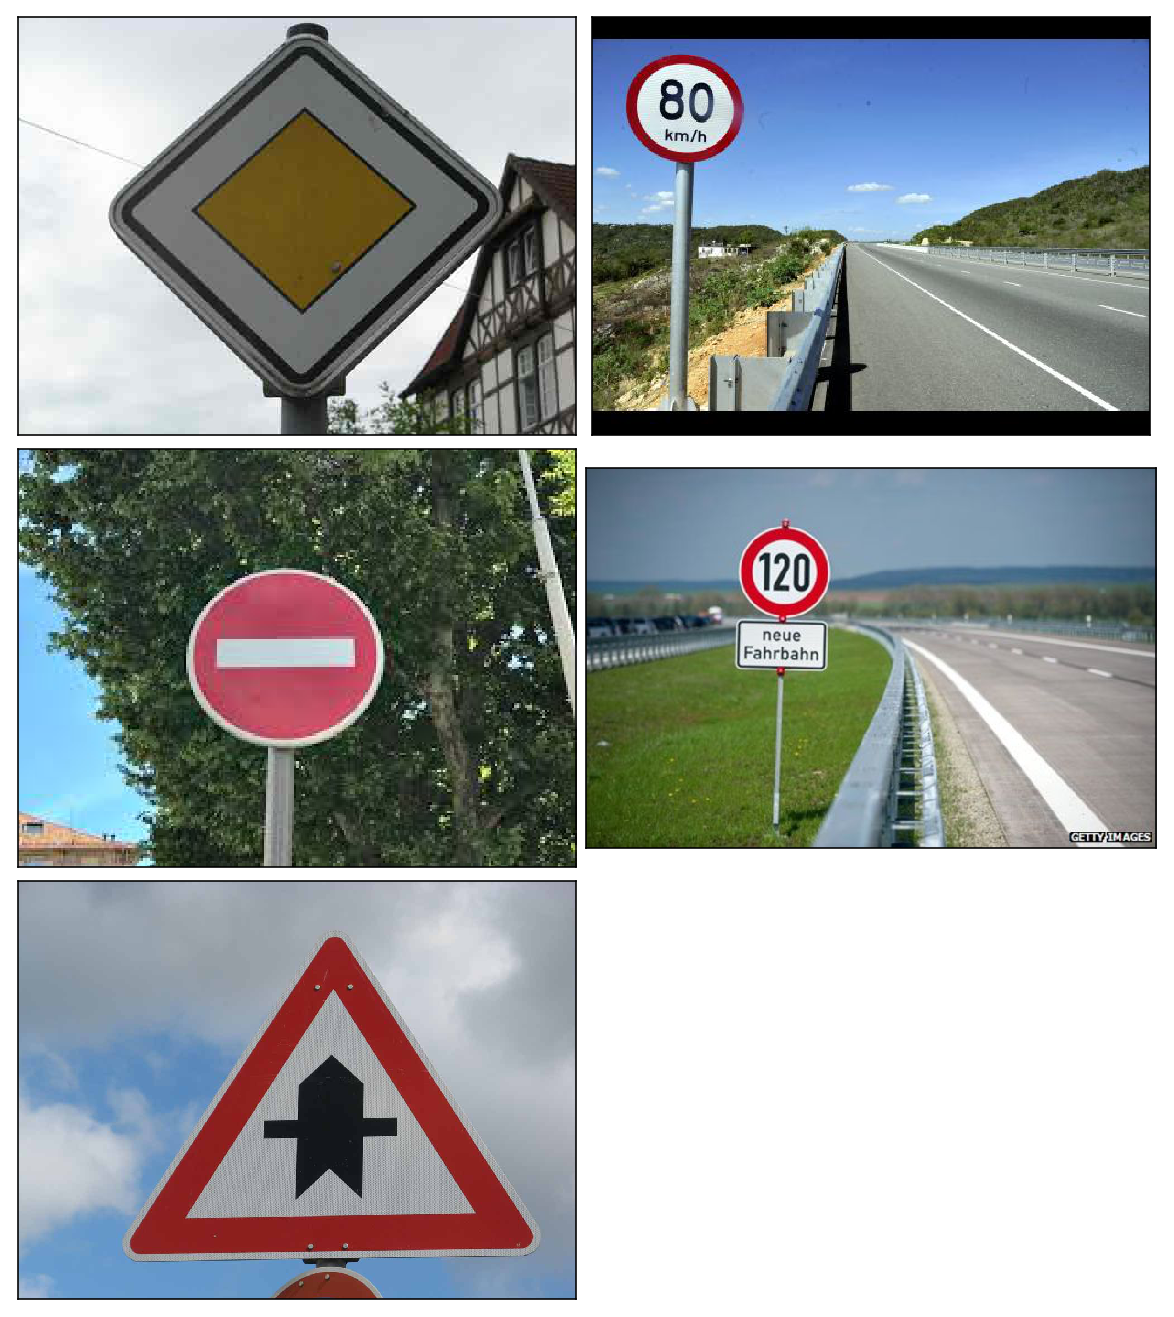

In [122]:
files = os.listdir(extract_path)
images = [mpimg.imread(extract_path + "/" + filename) for filename in files if filename != '.DS_Store']

def display_images_web(images, cmap=None):
    cols = 2
    rows = (len(images) + 1) // cols
    plt.figure(figsize=(8, 9))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i]
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
display_images_web(images)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
# Resize to 32x32x3 first
# def resize(x_imgs):
    

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")